In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler

import tensorflow
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from keras.callbacks import EarlyStopping

scaler = MinMaxScaler()

In [2]:
df = pd.read_csv("../Data/train_preprocessed.csv", low_memory=False)

features = ["Num_of_Loan", "Num_of_Delayed_Payment", "Interest_Rate", 'Annual_Income']
X = df[features].to_numpy()

y = df["Credit_Score"].to_numpy()

In [3]:
num = df.drop(columns=['Credit_Score']).select_dtypes(include=['number']).columns
cat = df.drop(columns=['Credit_Score', 'Customer_ID']).select_dtypes(include=['object']).columns

# Feature Selection with:
1. Mutual Information 
2. PCA
3. Gini (non quella di H.P.)
4. Random Forest (information Gain)

In [4]:
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif

#mutual_info_classif(df, y_norm)
MI_num = mutual_info_regression(df[num], y)
MI_num_scores = pd.Series(dict(zip(num, MI_num))).sort_values(ascending=False)

In [5]:
MI_cat = mutual_info_classif(df[cat].apply(LabelEncoder().fit_transform), y)
MI_cat_scores = pd.Series(dict(zip(cat, MI_cat))).sort_values(ascending=False)

In [6]:
MI_num_scores,  MI_cat_scores

(Outstanding_Debt            0.522636
 Monthly_Inhand_Salary       0.503022
 Total_EMI_per_month         0.469825
 Interest_Rate               0.173919
 Delay_from_due_date         0.121264
 Changed_Credit_Limit        0.115702
 Num_Credit_Inquiries        0.112785
 Num_Credit_Card             0.108598
 Credit_History_Age          0.103808
 Num_Bank_Accounts           0.102833
 Num_of_Delayed_Payment      0.084958
 Num_of_Loan                 0.083257
 Annual_Income               0.056527
 Monthly_Balance             0.030340
 Age                         0.014255
 Amount_invested_monthly     0.010890
 Credit_Utilization_Ratio    0.001319
 dtype: float64,
 Type_of_Loan             0.310955
 Credit_Mix               0.152144
 Payment_of_Min_Amount    0.108754
 Payment_Behaviour        0.005113
 Month                    0.001610
 Occupation               0.000000
 dtype: float64)

# Building the Model Datasets

In [15]:
features_cat = list(MI_cat_scores[MI_cat_scores > 0.10].index)
features_num = list(MI_num_scores[MI_num_scores > 0.10].index)

In [38]:
X_train, X_test, y_train, y_test = train_test_split(df[features_num + features_cat], y, test_size=0.2)

In [39]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from imblearn.pipeline import Pipeline 
from imblearn.over_sampling import RandomOverSampler


sampler = RandomOverSampler() 
X_train, y_train = sampler.fit_resample(X_train, y_train)


cat_preprocessor = Pipeline([("imputer", SimpleImputer(strategy="most_frequent")),
                            ("onehot", OneHotEncoder(sparse=True, handle_unknown="ignore"))])

num_preprocessor = Pipeline([
                            ("imputer", SimpleImputer(strategy="median"))])

preprocessor = ColumnTransformer([
    ("numerical", num_preprocessor, features_num),
    ("categorical", cat_preprocessor, features_cat)
])

## Transforming
X_train = preprocessor.fit_transform(X_train).todense()
X_test = preprocessor.transform(X_test)

scaler = MaxAbsScaler()
X_train = scaler.fit_transform(X_train).toarray()
X_val = scaler.transform(X_val).toarray()
X_test = scaler.transform(X_test).toarray()

In [40]:
n_input = X_train.shape[-1]
n_output = np.unique(y_norm).size

In [41]:
Arch = [
    Dense(units=n_input, activation='relu'),
    Dense(units=n_output, activation='linear')
]

model = Sequential(Arch)

In [42]:
opt = Adam(learning_rate=0.01)

model.compile(loss=SparseCategoricalCrossentropy(from_logits=True), optimizer=opt)

In [43]:
history = model.fit(X_train, y_train, epochs=100, validation_split=0.2)

Epoch 1/100
924/924 [==============================] - 81s 87ms/step - loss: 284.1951 - val_loss: 1.0849
Epoch 2/100
924/924 [==============================] - 79s 85ms/step - loss: 1.0261 - val_loss: 0.9952
Epoch 3/100
233/924 [======>.......................] - ETA: 56s - loss: 1.0072

KeyboardInterrupt: 

In [ ]:
logits = model(X_train)
f_X = tensorflow.nn.softmax(logits)

In [ ]:
y_hat = np.argmax(f_X, axis=1)

In [ ]:
np.unique(np.argmax(f_X, axis=1), return_counts=1)

(array([0, 1, 2], dtype=int64), array([   58,    12, 36868], dtype=int64))

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
print(classification_report(y_train, y_hat))

              precision    recall  f1-score   support

           0       0.60      0.01      0.01      6279
           1       0.33      0.00      0.00     11185
           2       0.53      1.00      0.69     19474

    accuracy                           0.53     36938
   macro avg       0.49      0.34      0.23     36938
weighted avg       0.48      0.53      0.37     36938



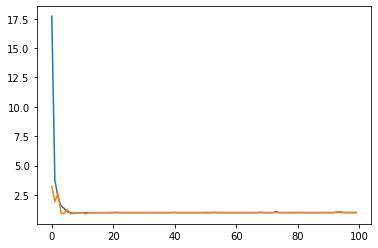

In [ ]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
#plt.xlim(20,100)